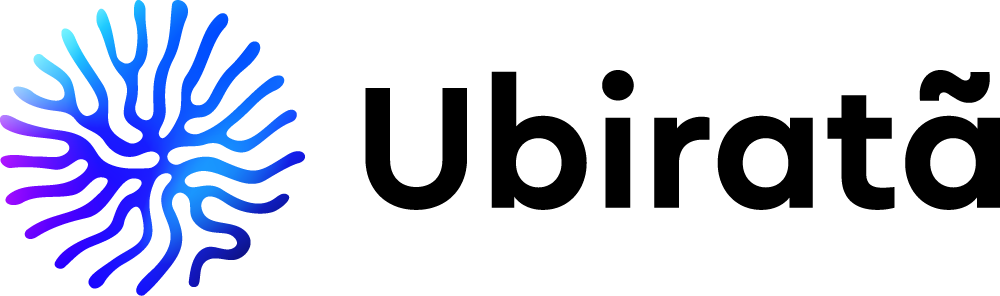

[Paleta de cores logo Ubiratã](https://coolors.co/ffffff-1738fe-57dcff-b7dcfe-9713ff-167bfc-1a9bfd)

**Estudo**

[Plot level sugarcane yield estimation by machine learning on multispectral images: A case study of Bundaberg, Australia](https://www.sciencedirect.com/science/article/pii/S2214317323000574?ref=pdf_download&fr=RR-2&rr=83818622f8c81aa1)

# Bibliotecas

In [431]:
! pip install xgboost -U --quiet
! pip install scikit-optimize -U --quiet

In [432]:
import  pandas as pd
import  numpy as np
import  plotly.express as px
import  plotly.graph_objects as go
import  xgboost as xgb
import time
import  plotly.figure_factory as ff

from    google.colab import drive
from    statsmodels.stats.outliers_influence import variance_inflation_factor
from    sklearn.preprocessing import StandardScaler
from    sklearn.model_selection import (train_test_split,
                                        RandomizedSearchCV)
from    sklearn.metrics import (r2_score,
                                mean_squared_error,
                                mean_absolute_error,
                                max_error,
                                mean_absolute_percentage_error)
from    sklearn.ensemble import RandomForestRegressor
from    skopt import BayesSearchCV
from    skopt.space import (Real,
                            Categorical,
                            Integer)
from    plotly.subplots import make_subplots

In [433]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [434]:
seed = 0

# Dataset

* bloco: índice da região de plantação e colheita de cana-de-açúcar
* talhao: índice da sub-região de plantação e colheita de cana-de-açúcar (Um bloco contém diversos talhões)
* area: área do talhão
* safra: ano que a cana-de-açúcar de cada talhão foi colhida
* data_colheita: data em que a cana-de-açúcar foi colhida
* TCH: Toneladas de cana-de-açúcar colhida por hectare
* NDVI_b01: NDVI é o nome dado a um popular índice de vegetação, e o “b01” corresponde ao índice no primeiro mês antes da colheita
* NDVI_bN: NDVI no N-ésimo mês antes da colheita

NDVI é a sigla para Índice de Vegetação da Diferença Normalizada (Normalized Difference Vegetation Index – do inglês).

É um índice usado para medir a saúde e a densidade da vegetação através de imagens de satélite, auxiliando no monitoramento das lavouras, e nas tomadas de decisão relacionadas ao manejo da cultura.

Este índice apresenta variação numérica de -1 a +1, sendo os valores positivos referentes ao vigor vegetativo da cultura, enquanto que os valores negativos indicam presença de água ou ausência de vegetação.

In [435]:
df = pd.read_csv('/content/drive/MyDrive/Teste Ubiratã/dataset_tch.csv',
                 sep=',',
                 encoding='utf-8')

df['data_colheita'] = pd.to_datetime(df['data_colheita'], format='%Y-%m-%d')

df.sort_values(by='data_colheita', inplace=True)

df.reset_index(drop=True, inplace=True)

df.head()

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534


# a)
Faça uma rápida análise exploratória desse dataset, por exemplo análises estatísticas das variáveis, gráficos de distribuição, etc.

In [436]:
df['safra'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [437]:
df.shape

(1906, 18)

In [438]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   bloco          1906 non-null   int64         
 1   talhao         1906 non-null   int64         
 2   area           1906 non-null   float64       
 3   safra          1906 non-null   int64         
 4   data_colheita  1906 non-null   datetime64[ns]
 5   TCH            1632 non-null   float64       
 6   NDVI_b01       1906 non-null   float64       
 7   NDVI_b02       1906 non-null   float64       
 8   NDVI_b03       1906 non-null   float64       
 9   NDVI_b04       1906 non-null   float64       
 10  NDVI_b05       1906 non-null   float64       
 11  NDVI_b06       1906 non-null   float64       
 12  NDVI_b07       1906 non-null   float64       
 13  NDVI_b08       1906 non-null   float64       
 14  NDVI_b09       1906 non-null   float64       
 15  NDVI_b10       1906 n

In [439]:
df[df.isnull().any(axis=1)]

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


In [440]:
# Verifica dados null em safras diferente de 2019
df[(df.isnull().any(axis=1)) &
   (df['safra'] != 2019)].transpose()

""
bloco
talhao
area
safra
data_colheita
TCH
NDVI_b01
NDVI_b02
NDVI_b03
NDVI_b04


## 2014 a 2018

In [441]:
df_2014_2018 = df[df['safra'] != 2019].copy()

### Estatística descritiva

In [442]:
df_2014_2018.drop(columns=['bloco', 'talhao', 'area', 'safra']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TCH,1632.0,75.234768,29.310767,2.202214,55.833929,74.971461,94.822667,149.940000
NDVI_b01,1632.0,0.534673,0.105107,0.298283,0.458951,0.514620,0.607857,0.822115
NDVI_b02,1632.0,0.564495,0.108507,0.287979,0.482802,0.545404,0.646742,0.845474
NDVI_b03,1632.0,0.601389,0.106995,0.297742,0.517665,0.600873,0.690522,0.833968
NDVI_b04,1632.0,0.642186,0.101480,0.304709,0.566234,0.663929,0.719432,0.834416
NDVI_b05,1632.0,0.661202,0.094809,0.308280,0.617135,0.684114,0.727902,0.847569
NDVI_b06,1632.0,0.661775,0.088612,0.325235,0.615927,0.682218,0.724550,0.815664
NDVI_b07,1632.0,0.642998,0.103593,0.284499,0.591899,0.667638,0.719172,0.817458
NDVI_b08,1632.0,0.622131,0.115120,0.221697,0.550753,0.648504,0.711083,0.840642
NDVI_b09,1632.0,0.574515,0.122088,0.161224,0.488638,0.590327,0.672990,0.805076


In [443]:
fig = px.box(df_2014_2018,
             y='TCH',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                    width=1200,
                    showlegend=False,
                    plot_bgcolor='#F9F9F9',
                    paper_bgcolor='#F9F9F9',
                    margin=dict(l=50,
                                r=50,
                                b=50,
                                t=50,
                                pad=0),
                    title='Variação da TCH por safra',
                    yaxis={'showgrid': True,
                           'title': '',
                           'dtick': 25,
                           'gridcolor': '#CBC9CD'},
                    xaxis={'showgrid': False,
                           'title': ''})

In [444]:
# Menor produção
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].min()].transpose()

,171
bloco,119
talhao,6
area,115.53
safra,2014
data_colheita,2014-09-09 00:00:00
TCH,2.202214
NDVI_b01,0.460535
NDVI_b02,0.484786
NDVI_b03,0.545309
NDVI_b04,0.620704


In [445]:
# Maior produção
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].max()].transpose()

,1277
bloco,387
talhao,2
area,81.39
safra,2018
data_colheita,2018-07-12 00:00:00
TCH,149.94
NDVI_b01,0.505337
NDVI_b02,0.539612
NDVI_b03,0.593915
NDVI_b04,0.625662


### TCH por safra

In [446]:
df_safra_tch = pd.DataFrame(df_2014_2018.groupby('safra')['TCH'].sum())

df_safra_tch.reset_index(drop=False, inplace=True)

df_safra_tch = df_safra_tch[df_safra_tch['safra'] != 2019]

df_safra_tch['mil_TCH'] = df_safra_tch['TCH'] / 1000

df_safra_tch

,safra,TCH,mil_TCH
0,2014,27877.678743,27.877679
1,2015,8294.836061,8.294836
2,2016,4160.731266,4.160731
3,2017,38653.503679,38.653504
4,2018,43796.391863,43.796392


In [447]:
df_safra_tch['mil_TCH'].describe()

count     5.000000
mean     24.556628
std      17.750762
min       4.160731
25%       8.294836
50%      27.877679
75%      38.653504
max      43.796392
Name: mil_TCH, dtype: float64

In [448]:
fig = px.line(df_safra_tch, x='safra', y='mil_TCH',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safra_tch['mil_TCH'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0),
                  title='Total de cana-de-açúcar por safra (em mil toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

### TCH por bloco

In [449]:
df_bloco_talhao = df_2014_2018.copy()

df_bloco_talhao['talhao'] = df_2014_2018['talhao'].astype(str)

fig = px.bar(df_bloco_talhao, x='bloco', y='TCH', color='talhao', animation_frame='safra')

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco, safra e talhões',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'},
                  sliders=[{'currentvalue': {'prefix': 'Safra: '}}])

### Correlações e multicolinearidade

[Correlation in machine learning — All you need to know](https://medium.com/@abdallahashraf90x/all-you-need-to-know-about-correlation-for-machine-learning-e249fec292e9)

#### Features

In [450]:
features = df.drop(['TCH'], axis=1).columns

features = features.drop('data_colheita')

features

Index(['bloco', 'talhao', 'area', 'safra', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03',
       'NDVI_b04', 'NDVI_b05', 'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09',
       'NDVI_b10', 'NDVI_b11', 'NDVI_b12'],
      dtype='object')

#### Target

In [451]:
target = df.drop(features, axis=1).columns

target = target.drop('data_colheita')

target

Index(['TCH'], dtype='object')

In [452]:
X_2014_2018 = df_2014_2018[features]

y_2014_2018 = df_2014_2018[target]

In [453]:
X_2014_2018

,bloco,talhao,area,safra,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,250,1,117.77,2018,0.426203,0.411605,0.468109,0.529646,0.619639,0.685097,0.682860,0.659134,0.572820,0.577737,0.500272,0.362951
1628,395,3,36.02,2018,0.442258,0.421180,0.469074,0.532711,0.596744,0.660622,0.691889,0.556852,0.535244,0.464160,0.452601,0.348077
1629,395,2,95.93,2018,0.386034,0.350786,0.391144,0.486252,0.582478,0.658411,0.708954,0.578486,0.545224,0.445497,0.405178,0.333850
1630,395,1,99.16,2018,0.382209,0.351820,0.389025,0.484159,0.580233,0.674486,0.731810,0.606615,0.572842,0.461748,0.415816,0.339220


In [454]:
y_2014_2018

,TCH
0,69.645161
1,75.522509
2,93.504762
3,51.913213
4,113.746898
...,...
1627,20.071738
1628,21.880668
1629,21.568922
1630,31.638724


In [455]:
correlacao = X_2014_2018.corr().round(2)

fig = px.imshow(correlacao, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r')

fig.update_layout(margin=dict(t=50,
                              r=50,
                              b=50,
                              l=50),
                  showlegend=False,
                  coloraxis_showscale=False,
                  width=800,
                  height=800)

fig.update_xaxes(side='top')

In [456]:
df_vif = pd.DataFrame()

df_vif['feature'] = X_2014_2018.columns

df_vif['variance_inflation_factor'] = [variance_inflation_factor(X_2014_2018, i) for i in range(X_2014_2018.shape[1])]


fig = go.Figure(go.Bar(y=df_vif['feature'],
                       x=df_vif['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#9713FF'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': True})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=False)

#### Scaler

In [457]:
scaler = StandardScaler()

X_2014_2018_scaled = scaler.fit_transform(X_2014_2018)

In [458]:
df_vif_scaled = pd.DataFrame()

df_vif_scaled['feature'] = X_2014_2018.columns

df_vif_scaled['variance_inflation_factor'] = [variance_inflation_factor(X_2014_2018_scaled, i) for i in range(X_2014_2018_scaled.shape[1])]


fig = go.Figure(go.Bar(y=df_vif_scaled['feature'],
                       x=df_vif_scaled['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif_scaled['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#9713FF'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância<br>Fatures redimensionadas',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': False})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=True)

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

[Fonte: Documentação StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

## 2019

In [459]:
df_2019 = df[df['safra'] == 2019].copy()

df_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


In [460]:
for nome_coluna, valores in df_2019.items():
    if 'NDVI_b' in nome_coluna:

        hist_data = [valores]
        group_labels = [str(nome_coluna)]

        media = df_2019[nome_coluna].mean()
        mediana = df_2019[nome_coluna].median()

        fig = ff.create_distplot(hist_data,
                                 group_labels,
                                 show_hist=False,
                                 show_rug=False)

        fig.update_layout(height=400,
                          width=1200,
                          showlegend=False,
                          plot_bgcolor='#F9F9F9',
                          paper_bgcolor='#F9F9F9',
                          margin=dict(l=50,
                                      r=50,
                                      b=50,
                                      t=80,
                                      pad=10),
                          title='Índice de Vegetação da Diferença Normalizada 2019 - ' + str(nome_coluna),
                          yaxis={'showgrid': False},
                          xaxis={'showgrid': False,
                                 'showticklabels': True})

        fig.add_vline(x=media, line_width=2, line_dash='dash',
                      line_color='green', annotation_text='Média',
                      annotation_font_color='green', annotation_position='top left')

        fig.add_vline(x=mediana, line_width=2, line_dash='dash',
                      line_color='red', annotation_text='Mediana',
                      annotation_font_color='red', annotation_position='bottom right')

        fig.show()

# b)

Desenvolva um modelo capaz de prever o TCH dos blocos do dataset para a safra de 2019 (atenção que a previsão deve ser no nível de blocos e não de talhões).

## Train test split

In [461]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_2014_2018,
                                                        y_2014_2018,
                                                        test_size=0.3,
                                                        random_state=seed)

print('\nShape do X_treino: ', X_treino.shape)
print('Shape do y_treino: ', y_treino.shape)

print('\nShape do X_teste: ', X_teste.shape)
print('Shape do y_teste: ', y_teste.shape)


Shape do X_treino:  (1142, 16)
Shape do y_treino:  (1142, 1)

Shape do X_teste:  (490, 16)
Shape do y_teste:  (490, 1)


In [462]:
X_treino_scaled = scaler.fit_transform(X_treino)

X_teste_scaled = scaler.transform(X_teste)

In [463]:
X_2019 = df_2019[features]

y_2019 = df_2019[target]

print('\nShape do X_2019: ', X_2019.shape)
print('Shape do y_2019: ', y_2019.shape)


Shape do X_2019:  (274, 16)
Shape do y_2019:  (274, 1)


In [464]:
X_2019_scaled = scaler.transform(X_2019)

In [465]:
X_2019_scaled

array([[ 1.19765505, -0.72968125,  0.82084762, ..., -0.42080779,
         0.30258042,  0.45063897],
       [ 0.76597079, -0.72968125,  1.67995924, ...,  0.62233758,
         0.84565602,  1.418351  ],
       [ 0.76597079, -0.27949433,  0.15985837, ..., -0.00516134,
         0.33178854,  0.73948103],
       ...,
       [ 1.62202262, -0.72968125,  0.81840597, ...,  0.06527754,
        -0.08490766, -0.61520278],
       [ 0.51720359, -0.72968125,  1.57950283, ...,  1.33891231,
         1.28296882,  1.26348279],
       [ 1.13912159, -0.50458779, -1.56673625, ...,  0.52203402,
         0.31962597,  0.52482482]])

Aplica-se .fit_transform() em X_treino enquanto usamos .transform() em X_test.

Isso é feito para dimensionar o conjunto de teste com os mesmos parâmetros do conjunto de treinamento, mas evitar vazamento de dados.

fit_transform calcula os valores de escala e os aplica, enquanto .transform apenas aplica os valores calculados.

## XGBoost

In [466]:
t1_xgbr_teste = time.perf_counter()


# Modelo XGBoost Regressor
modelo_xgbr = xgb.XGBRegressor()

params_xgbr = {'n_estimators':  [300, 400, 500, 600, 1000],
               'learning_rate': [0.1, 0.01, 0.001],
               'booster':       ['dart', 'gbtree'],  # Tree based models
               'eval_metric':   ['mae'],
               'objective':     ['reg:squarederror']}


# Random search dos melhores parametros
xgbr_rand_search = RandomizedSearchCV(modelo_xgbr,
                                      param_distributions=params_xgbr,
                                      n_iter=5,
                                      cv=5,
                                      scoring='neg_mean_squared_error',
                                      error_score='raise',
                                      verbose=3,
                                      random_state=seed)

xgbr_rand_search.fit(X_treino_scaled, y_treino)


# Define o modelo XGBRegressor com melhores parâmetros
melhor_xgbr_regressor = xgbr_rand_search.best_estimator_

melhor_xgbr_regressor.fit(X_treino_scaled,
                          y_treino,
                          verbose=False)

pred_xgbr_teste = melhor_xgbr_regressor.predict(X_teste_scaled)

pred_xgbr_teste = pd.Series(pred_xgbr_teste, index=y_teste.index)


t2_xgbr_teste = time.perf_counter()
tempo_total_xgbr_teste = t2_xgbr_teste - t1_xgbr_teste
print(f'Tempo de execução: {tempo_total_xgbr_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_xgbr_teste) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-654.199 total time= 1.3min
[CV 2/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-578.057 total time=  42.5s
[CV 3/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-617.856 total time=  44.6s
[CV 4/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-734.991 total time=  39.2s
[CV 5/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-534.973 total time=  43.2s
[CV 1/5] END booster=gbtree, eval_metric=mae, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-681.102 total time=   3.4s
[CV 2/5] END booster=gbtree, eval_metric=mae, learning_rate=0.001, n_est

In [467]:
pred_xgbr_teste

1336    84.425903
587     70.398071
602     73.481644
527     95.508804
76      84.144318
          ...    
330     22.211693
1010    70.741264
1038    64.154762
1624    42.355469
56      96.448944
Length: 490, dtype: float32

In [468]:
xgbr_rand_search.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 500,
 'learning_rate': 0.1,
 'eval_metric': 'mae',
 'booster': 'dart'}

In [501]:
# Métricas de avaliacao
rmse_xgbr_teste = mean_squared_error(y_teste, pred_xgbr_teste.values, squared=False)
rmse_xgbr_teste = round(rmse_xgbr_teste, 2)
print(f'RMSE XGBoost teste: {rmse_xgbr_teste}')

mae_xgbr_teste = mean_absolute_error(y_teste, pred_xgbr_teste.values)
mae_xgbr_teste = round(mae_xgbr_teste, 2)
print(f'MAE XGBoost teste: {mae_xgbr_teste}')

max_error_xgbr_teste = max_error(y_teste, pred_xgbr_teste.values)
max_error_xgbr_teste = round(max_error_xgbr_teste, 2)
print(f'Max error XGBoost teste: {max_error_xgbr_teste}')

mape_xgbr_teste = mean_absolute_percentage_error(y_teste, pred_xgbr_teste.values) * 100
mape_xgbr_teste = round(mape_xgbr_teste, 2)
print(f'MAPE XGBoost teste: {rmse_xgbr_teste}%')

r2_score_xgbr_teste = r2_score(y_teste, pred_xgbr_teste.values) * 100
r2_score_xgbr_teste = round(r2_score_xgbr_teste, 2)
print(f'R2 XGBoost teste: {r2_score_xgbr_teste}%')

RMSE XGBoost teste: 26.12
MAE XGBoost teste: 20.17
Max error XGBoost teste: 88.65
MAPE XGBoost teste: 26.12%
R2 XGBoost teste: 21.6%


### Pred TCH 2019

In [502]:
t1 = time.perf_counter()

pred_tch_2019_xgbr_regressor = melhor_xgbr_regressor.predict(X_2019_scaled)

pred_tch_2019_xgbr_regressor = pd.Series(pred_tch_2019_xgbr_regressor, index=y_2019.index)

y_2019['TCH_xgbr_regressor'] = pred_tch_2019_xgbr_regressor

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.05 segundos
Tempo de execução: 0.00 minutos


In [503]:
y_2019

,TCH,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
1632,NaN,101.668465,98.237441,96.906224
1633,NaN,113.288147,102.958156,101.611020
1634,NaN,86.985474,87.150928,91.257370
1635,NaN,62.832405,64.340118,67.866249
1636,NaN,75.918159,69.783855,78.328924
...,...,...,...,...
1901,NaN,86.840157,85.782684,84.788703
1902,NaN,73.807526,80.542291,82.211810
1903,NaN,79.272957,75.967304,77.238965
1904,NaN,88.464394,88.092848,91.917167


## Random Forest

In [504]:
t1_rand_forest_teste = time.perf_counter()


# Modelo Random Forest
rand_forest_regressor = RandomForestRegressor(random_state=seed)

param_space = {'bootstrap': [True, False],                  # Statistical resampling technique that involves random sampling of a dataset
               'criterion': ['squared_error'],              # The function to measure the quality of a split
               'max_depth': [2, 4, 8, 16, 32],              # The maximum depth of the tree
               'min_samples_leaf': [2, 3, 4],               # The minimum number of samples required to be at a leaf node
               'min_samples_split': [2, 3, 4, 5],           # The minimum number of samples required to split an internal node
               'n_estimators': [300, 400, 500, 600, 1000]}  # The number of trees in the forest

# Random search dos melhores parametros
rand_forest_search = RandomizedSearchCV(rand_forest_regressor,
                                        param_space,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=5,
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=3,
                                        random_state=seed)

rand_forest_search.fit(X_treino_scaled, np.ravel(y_treino))


# Define o modelo Random Forest com melhores parâmetros
melhor_rand_forest_regressor = RandomForestRegressor(**rand_forest_search.best_params_)

melhor_rand_forest_regressor.fit(X_treino_scaled, np.ravel(y_treino))

pred_rand_forest_teste = melhor_rand_forest_regressor.predict(X_teste_scaled)

pred_rand_forest_teste = pd.Series(pred_rand_forest_teste, index=y_teste.index)


t2_rand_forest_teste = time.perf_counter()
tempo_total_rand_forest_teste = t2_rand_forest_teste - t1_rand_forest_teste
print(f'Tempo de execução: {tempo_total_rand_forest_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_rand_forest_teste) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Tempo de execução: 160.77 segundos
Tempo de execução: 2.68 minutos


In [505]:
pred_rand_forest_teste

1336    78.815247
587     76.112292
602     86.832842
527     93.912820
76      81.295823
          ...    
330     25.790756
1010    72.698952
1038    57.358948
1624    42.830507
56      96.311404
Length: 490, dtype: float64

In [506]:
rand_forest_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 16,
 'criterion': 'squared_error',
 'bootstrap': True}

In [507]:
# Métricas de avaliacao
rmse_rand_forest_teste = mean_squared_error(y_teste, pred_rand_forest_teste.values, squared=False)
rmse_rand_forest_teste = round(rmse_rand_forest_teste, 2)
print(f'RMSE Random Forest teste: {rmse_rand_forest_teste}')

mae_rand_forest_teste = mean_absolute_error(y_teste, pred_rand_forest_teste.values)
mae_rand_forest_teste = round(mae_rand_forest_teste, 2)
print(f'MAE Random Forest teste: {mae_rand_forest_teste}')

max_error_rand_forest_teste = max_error(y_teste, pred_rand_forest_teste.values)
max_error_rand_forest_teste = round(max_error_rand_forest_teste, 2)
print(f'Max error Random Forest teste: {max_error_rand_forest_teste}')

mape_rand_forest_teste = mean_absolute_percentage_error(y_teste, pred_rand_forest_teste.values) * 100
mape_rand_forest_teste = round(mape_rand_forest_teste, 2)
print(f'MAPE Random Forest teste: {rmse_rand_forest_teste}%')

r2_score_rand_forest_teste = r2_score(y_teste, pred_rand_forest_teste.values) * 100
r2_score_rand_forest_teste = round(r2_score_rand_forest_teste, 2)
print(f'R2 Random Forest teste: {r2_score_rand_forest_teste}%')

RMSE Random Forest teste: 24.78
MAE Random Forest teste: 18.98
Max error Random Forest teste: 81.39
MAPE Random Forest teste: 24.78%
R2 Random Forest teste: 29.43%


**Random Search**

In random search, you specify a distribution of hyperparameter values, and a set of random combinations of these values are sampled and used to train and evaluate the model.

Random search is often faster than grid search, as it does not evaluate all possible combinations of hyperparameters.

[Fonte: A Comprehensive Guide to Random Forest Regression](https://medium.com/@bhatshrinath41/a-comprehensive-guide-to-random-forest-regression-43da559342bf)

### Pred TCH 2019

In [508]:
t1 = time.perf_counter()

pred_tch_2019_rand_forest_regressor = melhor_rand_forest_regressor.predict(X_2019_scaled)

pred_tch_2019_rand_forest_regressor = pd.Series(pred_tch_2019_rand_forest_regressor, index=y_2019.index)

y_2019['TCH_rand_forest_regressor'] = pred_tch_2019_rand_forest_regressor

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.05 segundos
Tempo de execução: 0.00 minutos


In [509]:
y_2019

,TCH,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
1632,NaN,101.668465,99.330796,96.906224
1633,NaN,113.288147,103.528298,101.611020
1634,NaN,86.985474,89.109628,91.257370
1635,NaN,62.832405,65.631891,67.866249
1636,NaN,75.918159,73.653920,78.328924
...,...,...,...,...
1901,NaN,86.840157,86.270721,84.788703
1902,NaN,73.807526,82.384034,82.211810
1903,NaN,79.272957,74.551421,77.238965
1904,NaN,88.464394,88.973109,91.917167


## Random Forest Bayes

**Otimização Bayesian**

In Bayesian optimization, a probabilistic model is used to model the unknown function that maps hyperparameters to the model’s performance.

The model is then used to guide the search for the optimal hyperparameters.

[Fonte: A Comprehensive Guide to Random Forest Regression](https://medium.com/@bhatshrinath41/a-comprehensive-guide-to-random-forest-regression-43da559342bf)

At a high-level, Bayesian optimization methods are efficient because they choose the next hyperparameters in an informed manner.

The basic idea is: spend a little more time selecting the next hyperparameters in order to make fewer calls to the objective function.

[Fonte: A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)

In [510]:
t1_rand_forest_bayes_teste = time.perf_counter()


# Modelo Random Forest
rand_forest_regressor = RandomForestRegressor(random_state=seed)

search_space = {'bootstrap': Categorical([True, False]),
                'max_depth': Integer(6, 20),
                'max_features': Categorical(['sqrt', 'log2']),
                'min_samples_leaf': Integer(2, 10),
                'min_samples_split': Integer(2, 5),
                'n_estimators': Integer(100, 500)}

forest_bayes_search = BayesSearchCV(rand_forest_regressor,
                                    search_space,
                                    scoring='neg_mean_absolute_error',
                                    n_iter=5,
                                    cv=5,
                                    n_jobs=-1,
                                    random_state=seed)

forest_bayes_search.fit(X_treino, np.ravel(y_treino))

melhor_rand_forest_bayes = RandomForestRegressor(**forest_bayes_search.best_params_)

melhor_rand_forest_bayes.fit(X_treino_scaled, np.ravel(y_treino))

pred_rand_forest_bayes_teste = melhor_rand_forest_bayes.predict(X_teste_scaled)

pred_rand_forest_bayes_teste = pd.Series(pred_rand_forest_bayes_teste, index=y_teste.index)


t2_rand_forest_bayes_teste = time.perf_counter()
tempo_total_rand_forest_bayes_teste = t2_rand_forest_bayes_teste - t1_rand_forest_bayes_teste
print(f'Tempo de execução: {tempo_total_rand_forest_bayes_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_rand_forest_bayes_teste) / 60:.2f} minutos')

Tempo de execução: 25.67 segundos
Tempo de execução: 0.43 minutos


In [511]:
pred_rand_forest_bayes_teste

1336    79.130526
587     81.993276
602     82.653543
527     91.526575
76      80.963102
          ...    
330     28.798281
1010    74.606319
1038    54.858876
1624    46.075157
56      93.892507
Length: 490, dtype: float64

In [512]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 17),
             ('max_features', 'log2'),
             ('min_samples_leaf', 6),
             ('min_samples_split', 4),
             ('n_estimators', 371)])

In [513]:
# Métricas de avaliacao
rmse_rand_forest_bayes_teste = mean_squared_error(y_teste, pred_rand_forest_bayes_teste.values, squared=False)
rmse_rand_forest_bayes_teste = round(rmse_rand_forest_bayes_teste, 2)
print(f'RMSE Random Forest Bayes teste: {rmse_rand_forest_bayes_teste}')

mae_rand_forest_bayes_teste = mean_absolute_error(y_teste, pred_rand_forest_bayes_teste.values)
mae_rand_forest_bayes_teste = round(mae_rand_forest_bayes_teste, 2)
print(f'MAE Random Forest Bayes teste: {mae_rand_forest_bayes_teste}')

max_error_rand_forest_bayes_teste = max_error(y_teste, pred_rand_forest_bayes_teste.values)
max_error_rand_forest_bayes_teste = round(max_error_rand_forest_bayes_teste, 2)
print(f'Max error Random Forest Bayes teste: {max_error_rand_forest_bayes_teste}')

mape_rand_forest_bayes_teste = mean_absolute_percentage_error(y_teste, pred_rand_forest_bayes_teste.values) * 100
mape_rand_forest_bayes_teste = round(mape_rand_forest_bayes_teste, 2)
print(f'MAPE Random Forest Bayes teste: {rmse_rand_forest_bayes_teste}%')

r2_score_rand_forest_bayes_teste = r2_score(y_teste, pred_rand_forest_bayes_teste.values) * 100
r2_score_rand_forest_bayes_teste = round(r2_score_rand_forest_bayes_teste, 2)
print(f'R2 Random Forest Bayes teste: {r2_score_rand_forest_bayes_teste}%')

RMSE Random Forest Bayes teste: 24.77
MAE Random Forest Bayes teste: 19.09
Max error Random Forest Bayes teste: 79.74
MAPE Random Forest Bayes teste: 24.77%
R2 Random Forest Bayes teste: 29.51%


### Pred TCH 2019

In [514]:
t1 = time.perf_counter()

pred_tch_2019_rand_forest_bayes = melhor_rand_forest_bayes.predict(X_2019_scaled)

pred_tch_2019_rand_forest_bayes = pd.Series(pred_tch_2019_rand_forest_bayes, index=y_2019.index)

y_2019['TCH_rand_forest_bayes'] = pred_tch_2019_rand_forest_bayes

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.03 segundos
Tempo de execução: 0.00 minutos


In [515]:
y_2019

,TCH,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
1632,NaN,101.668465,99.330796,97.761008
1633,NaN,113.288147,103.528298,100.999435
1634,NaN,86.985474,89.109628,89.762906
1635,NaN,62.832405,65.631891,66.867877
1636,NaN,75.918159,73.653920,76.889785
...,...,...,...,...
1901,NaN,86.840157,86.270721,86.302672
1902,NaN,73.807526,82.384034,82.086488
1903,NaN,79.272957,74.551421,78.679245
1904,NaN,88.464394,88.973109,91.405690


## Coleta de resultados

In [516]:
tch_xgbr_regressor = pd.concat([df_2014_2018['TCH'], y_2019['TCH_xgbr_regressor']], axis=0)

tch_rand_forest_regressor = pd.concat([df_2014_2018['TCH'], y_2019['TCH_rand_forest_regressor']], axis=0)

tch_rand_forest_bayes = pd.concat([df_2014_2018['TCH'], y_2019['TCH_rand_forest_bayes']], axis=0)

In [517]:
df_2014_2019 = df.copy()

df_2014_2019['TCH_xgbr_regressor'] = tch_xgbr_regressor

df_2014_2019['TCH_rand_forest_regressor'] = tch_rand_forest_regressor

df_2014_2019['TCH_rand_forest_bayes'] = tch_rand_forest_bayes

df_2014_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,...,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,69.645161,69.645161,69.645161
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,...,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,75.522509,75.522509,75.522509
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,...,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,93.504762,93.504762,93.504762
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,...,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,51.913213,51.913213,51.913213
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,...,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,113.746898,113.746898,113.746898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,86.840157,86.270721,86.302672
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,73.807526,82.384034,82.086488
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,79.272957,74.551421,78.679245
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,88.464394,88.973109,91.405690


In [518]:
df_2014_2019_agrupado_bloco = df_2014_2019[df_2014_2019['safra'] == 2019].groupby('bloco').sum()

df_2014_2019_agrupado_bloco.reset_index(drop=False, inplace=True)

df_2014_2019_agrupado_bloco

<ipython-input-518-be2eee3b3380>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,bloco,talhao,area,safra,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
0,13,1,67.28,2019,0.0,0.688200,0.718599,0.732889,0.700157,0.702455,0.479158,0.550311,0.444463,0.409690,0.427989,0.486711,0.501093,92.556557,88.652868,89.850162
1,16,1,31.34,2019,0.0,0.561317,0.611405,0.674954,0.662746,0.665600,0.525441,0.595787,0.593090,0.375706,0.471425,0.384695,0.375208,71.576385,78.011166,78.458013
2,17,21,432.42,12114,0.0,3.999530,4.166051,4.156167,3.959398,3.891229,2.797747,3.517707,2.739435,2.409677,2.380063,2.830045,2.980745,517.198029,508.080381,503.140680
3,19,1,94.64,2019,0.0,0.557562,0.622865,0.743437,0.764749,0.750387,0.686653,0.688869,0.626937,0.370526,0.477837,0.326793,0.303321,97.945457,94.501988,90.069087
4,20,3,128.85,4038,0.0,1.138048,1.223652,1.463459,1.500162,1.481539,1.377236,1.444101,1.322068,0.748208,0.753024,0.726219,0.660565,195.707047,178.861035,173.427528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,463,21,552.85,12114,0.0,2.479996,3.166682,3.447394,4.088144,4.343657,3.483643,4.093422,3.612785,3.508883,2.524095,2.055733,1.802740,380.638565,390.681013,406.932933
111,464,6,264.29,6057,0.0,2.031889,2.246860,1.817471,2.187716,1.965861,2.011033,1.503895,1.250442,1.482647,1.725189,1.862911,1.667356,297.020569,266.489131,260.118930
112,468,12,150.14,6057,0.0,2.230861,2.251037,2.300944,1.710271,2.304834,1.894286,1.909624,1.337930,1.050307,1.252623,1.481919,1.501413,292.872726,297.314335,285.260508
113,473,3,219.79,4038,0.0,0.897920,1.156609,1.346961,1.518553,1.454349,1.469960,1.432192,1.402224,1.316593,0.976624,0.668293,0.724418,138.763000,162.459653,159.224121


In [519]:
df_safras_tch = pd.DataFrame(df_2014_2019.groupby('safra')['TCH_xgbr_regressor',
                                                           'TCH_rand_forest_regressor',
                                                           'TCH_rand_forest_bayes'].sum())

df_safras_tch.reset_index(drop=False, inplace=True)

df_safras_tch['mil_TCH_xgbr_regressor'] = df_safras_tch['TCH_xgbr_regressor'] / 1000

df_safras_tch['mil_TCH_rand_forest_regressor'] = df_safras_tch['TCH_rand_forest_regressor'] / 1000

df_safras_tch['mil_TCH_rand_forest_bayes'] = df_safras_tch['TCH_rand_forest_bayes'] / 1000

df_safras_tch

<ipython-input-519-2c9e4d59b813>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,safra,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes,mil_TCH_xgbr_regressor,mil_TCH_rand_forest_regressor,mil_TCH_rand_forest_bayes
0,2014,27877.678743,27877.678743,27877.678743,27.877679,27.877679,27.877679
1,2015,8294.836061,8294.836061,8294.836061,8.294836,8.294836,8.294836
2,2016,4160.731266,4160.731266,4160.731266,4.160731,4.160731,4.160731
3,2017,38653.503679,38653.503679,38653.503679,38.653504,38.653504,38.653504
4,2018,43796.391863,43796.391863,43796.391863,43.796392,43.796392,43.796392
5,2019,22190.183838,21931.184499,22185.611022,22.190184,21.931184,22.185611


## Análise gráfica

### XGBRegressor

In [520]:
fig = px.box(df_2014_2019,
             y='TCH_xgbr_regressor',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH (2019 por XGBRegressor)',
                  yaxis={'showgrid': True,
                         'title': '',
                         'dtick': 25,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [521]:
df_2014_2019_agrupado_bloco['bloco'] = df_2014_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_agrupado_bloco, x='bloco', y='TCH_xgbr_regressor',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

In [522]:
fig = px.line(df_safras_tch, x='safra', y='mil_TCH_xgbr_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_TCH_xgbr_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

### Random Forest

In [523]:
fig = px.box(df_2014_2019,
             y='TCH_rand_forest_regressor',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH (2019 por Random Forest)',
                  yaxis={'showgrid': True,
                         'title': '',
                         'dtick': 25,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [524]:
df_2014_2019_agrupado_bloco['bloco'] = df_2014_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_agrupado_bloco,
             x='bloco',
             y='TCH_rand_forest_regressor',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (Random Forest)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

In [525]:
fig = px.line(df_safras_tch, x='safra', y='mil_TCH_rand_forest_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_TCH_rand_forest_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por Random Forest)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

### Random Forest Bayes

In [526]:
fig = px.box(df_2014_2019,
             y='TCH_rand_forest_bayes',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH (2019 por Random Forest Bayes)',
                  yaxis={'showgrid': True,
                         'title': '',
                         'dtick': 25,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [527]:
df_2014_2019_agrupado_bloco['bloco'] = df_2014_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_agrupado_bloco,
             x='bloco',
             y='TCH_rand_forest_bayes',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (Random Forest Bayes)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

In [528]:
fig = px.line(df_safras_tch, x='safra', y='mil_TCH_rand_forest_bayes',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_TCH_rand_forest_bayes'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por Random Forest Bayes)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

## Análise entre estimativas de safra 2019

In [529]:
df_tch_2019 = df_2014_2019[df_2014_2019['safra'] == 2019]

df_tch_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,...,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,101.668465,99.330796,97.761008
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,...,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,113.288147,103.528298,100.999435
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,...,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,86.985474,89.109628,89.762906
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,...,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,62.832405,65.631891,66.867877
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,...,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,75.918159,73.653920,76.889785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,86.840157,86.270721,86.302672
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,73.807526,82.384034,82.086488
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,79.272957,74.551421,78.679245
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,88.464394,88.973109,91.405690


In [530]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Box(y=df_tch_2019['TCH_xgbr_regressor'],
                     name='XGBRegressor',
                     marker_color='#1738FE'))

fig.add_trace(go.Box(y=df_tch_2019['TCH_rand_forest_regressor'],
                     name='Random Forest',
                     marker_color='#9713FF'))

fig.add_trace(go.Box(y=df_tch_2019['TCH_rand_forest_bayes'],
                     name='Random Forest Bayes',
                     marker_color='#1A9BFD'))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=100,
                              pad=0),
                  title='Variação da TCH estimadas para 2019',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'dtick': 4,
                         'tick0': 60},
                  xaxis={'showgrid': False,
                         'gridcolor': '#CBC9CD'})

# c)
Qual o erro esperado do modelo para a safra de 2019? Utilize a métrica de erro que você julgar necessária, podendo ser utilizada mais de uma.

**RMSE**

Is used to measure the deviation between predicted and observed values.

The RMSE is calculated to correlate with larger values and is more sensitive to outliers.

**MAE**

Gives a good indication of the actual situation of the error in the predicted values.

**MAPE**

Indicates the average deviation between the predicted and observed values.

---

The smaller the MAPE, RMSE and MAE values, the better the prediction performance of the model and the higher the prediction accuracy.

## Métricas

In [531]:
metricas = [[rmse_xgbr_teste, mae_xgbr_teste, max_error_xgbr_teste,
                mape_xgbr_teste, r2_score_xgbr_teste, tempo_total_xgbr_teste],

            [rmse_rand_forest_teste, mae_rand_forest_teste, max_error_rand_forest_teste,
                mape_rand_forest_teste, r2_score_rand_forest_teste, tempo_total_rand_forest_teste],

            [rmse_rand_forest_bayes_teste, mae_rand_forest_bayes_teste, max_error_rand_forest_bayes_teste,
                mape_rand_forest_bayes_teste, r2_score_rand_forest_bayes_teste, tempo_total_rand_forest_bayes_teste]]

colunas = ['rmse', 'mae', 'max_error', 'mape', 'r2_score', 'tempo_total_teste']

index = ['XGBRegressor<br>teste', 'Random Forest<br>teste', 'Random Forest Bayes<br>teste']

df_metricas = pd.DataFrame(data=metricas,
                           columns=colunas,
                           index=index)

df_metricas['mil_TCH_pred_2019'] = None

df_metricas['mil_TCH_pred_2019'].iloc[0] = df_safras_tch['mil_TCH_xgbr_regressor'].iloc[-1].round(2)

df_metricas['mil_TCH_pred_2019'].iloc[1] = df_safras_tch['mil_TCH_rand_forest_regressor'].iloc[-1].round(2)

df_metricas['mil_TCH_pred_2019'].iloc[2] = df_safras_tch['mil_TCH_rand_forest_bayes'].iloc[-1].round(2)

df_metricas

,rmse,mae,max_error,mape,r2_score,tempo_total_teste,mil_TCH_pred_2019
XGBRegressor<br>teste,26.12,20.17,88.65,43.28,21.60,987.593665,22.19
Random Forest<br>teste,24.78,18.98,81.39,42.37,29.43,160.766249,21.93
Random Forest Bayes<br>teste,24.77,19.09,79.74,42.55,29.51,25.667450,22.19


## Análise gráfica

In [538]:
fig = make_subplots(rows=4, cols=2,
                    subplot_titles=('RMSE', 'MAE',
                                    'Max error', 'MAPE',
                                    'R2 score', 'Tempo de teste (segundos)',
                                    'Mil TCH para 2019'),
                    horizontal_spacing = 0.05,
                    vertical_spacing = 0.1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['rmse'],
                     text=df_metricas['rmse'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#1738FE',
                             'line.width': 0}),
              row=1, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mae'],
                     text=df_metricas['mae'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#57DCFF',
                             'line.width': 0}),
              row=1, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['max_error'],
                     text=df_metricas['max_error'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#B7DCFE',
                             'line.width': 0}),
              row=2, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mape'],
                     text=df_metricas['mape'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#9713FF',
                             'line.width': 0}),
              row=2, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['r2_score'],
                     text=df_metricas['r2_score'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#167BFC',
                             'line.width': 0}),
              row=3, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['tempo_total_teste'],
                     text=df_metricas['tempo_total_teste'].round(2),
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#167BFC',
                             'line.width': 0}),
              row=3, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mil_TCH_pred_2019'],
                     text=df_metricas['mil_TCH_pred_2019'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#1A9BFD',
                             'line.width': 0}),
              row=4, col=1)

fig.update_layout(height=900,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0))

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=1, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=1, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=2, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=2, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=3, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=3, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=4, col=1)